In [1]:
import os
import time
from hydra_zen import instantiate, make_config, builds, to_yaml, load_from_yaml, launch
import sys
import pickle

from pathlib import Path

import jax.numpy as np
from jax import vmap, random, grad, jit
import jax.numpy.linalg as lin
from functools import partial
from tqdm import tqdm

from grassgp.grassmann import valid_grass_point, sample_karcher_mean, grass_dist, grass_exp, valid_grass_tangent, grass_log, convert_to_projs, compute_barycenter
from grassgp.means import zero_mean
from grassgp.kernels import rbf
from grassgp.models_optimised import GrassGP
from grassgp.plot_utils import flatten_samples, plot_grass_dists
from grassgp.utils import to_dictconf, get_save_path, vec, unvec
from grassgp.utils import safe_save_jax_array_dict as safe_save
from grassgp.utils import load_and_convert_to_samples_dict as load_data

import chex
from chex import assert_shape, assert_rank
from dataclasses import dataclass, field
from typing import Tuple, Union, Callable, Tuple

import numpyro
from numpyro.infer import SVI, Trace_ELBO, autoguide, init_to_value
import numpyro.distributions as dist

from grassgp.inference import run_inference

import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/yanni/.cache/pypoetry/virtualenvs/grassgp-JZ6xTmeL-py3.10/lib/python3.10/site-packages/jax/_src/deprecations.py:51: DeprecationWarning: jax.interpreters.xla.xla_call_p is deprecated. Please use jax.experimental.pjit.pjit_p instead.
  warnings.warn(message, DeprecationWarning)


In [2]:
def print_file(x: Path):
    with x.open("r") as f:
        print(f.read())

In [3]:
def pickle_load(name: str):
    with open(name, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [4]:
def pickle_save(obj, name: str):
    with open(name, 'wb') as f:
        pickle.dump(obj, f)

# Load results and analyse

In [5]:
base_path = Path(os.getcwd())
output_folder = "multirun"
date = "2023-06-20"
time = "11-19-15"

In [6]:
id_num = "0"

In [7]:
job_path = base_path / output_folder / date / time / id_num
assert job_path.exists()

In [8]:
config = load_from_yaml(job_path / ".hydra" / "config.yaml")
overrides = load_from_yaml(job_path / ".hydra" / "overrides.yaml")

In [9]:
print("Overrides used for training:")
print(to_yaml(overrides))

Overrides used for training:
- model.ell=0.01
- model.cov_jitter=0.0001



In [10]:
dataset_path = job_path / "training_test_data.pickle"
assert dataset_path.exists()
training_test_data = pickle_load(dataset_path)

s_train = np.array(training_test_data['s_train'])
s_test = np.array(training_test_data['s_test'])

Ws_train = np.array(training_test_data['Ws_train'])
Ws_test = np.array(training_test_data['Ws_test'])

log_Ws_train = np.array(training_test_data['log_Ws_train'])
log_Ws_test = np.array(training_test_data['log_Ws_test'])

anchor_point = np.array(training_test_data['anchor_point'])

d, n = anchor_point.shape

In [11]:
assert vmap(lambda W: valid_grass_point(W))(Ws_test).all()

In [12]:
i=0
W0 = Ws_test[i]

In [18]:
W0 = np.eye(100)[:,0][:,None]

In [19]:
dists = vmap(lambda W: grass_dist(W, W0))(Ws_test)

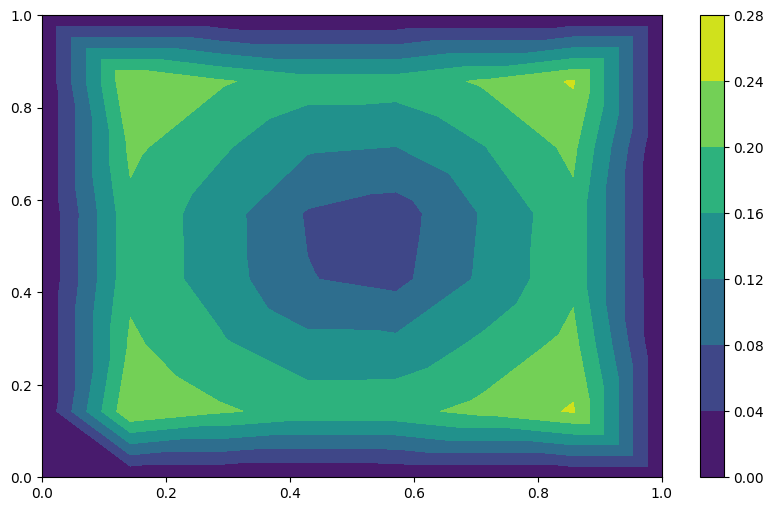

In [20]:
fig, ax = plt.subplots()
tcf = ax.tricontourf(s_test[:,0],s_test[:,1],dists)
fig.colorbar(tcf)
plt.show()

In [18]:
print_file(job_path / "hmc_log.txt")


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
 Omega_diag_chol[0]      1.47      1.56      0.96      0.02      3.28   1624.18      1.00
 Omega_diag_chol[1]      8.11      1.23      7.95      6.14     10.03    717.23      1.00
 Omega_diag_chol[2]      7.32      1.12      7.20      5.58      9.11    905.37      1.00
 Omega_diag_chol[3]      2.12      0.40      2.08      1.47      2.74   1565.03      1.00
 Omega_diag_chol[4]      0.95      0.34      0.95      0.35      1.51   1494.50      1.00
 Omega_diag_chol[5]      0.65      0.35      0.64      0.03      1.12   1136.56      1.00
 Omega_diag_chol[6]      0.18      0.11      0.16      0.02      0.34   2559.00      1.00
 Omega_diag_chol[7]      0.22      0.14      0.19      0.02      0.42   2137.46      1.00
 Omega_diag_chol[8]      0.18      0.11      0.16      0.02      0.35   2653.02      1.00
 Omega_diag_chol[9]      0.18      0.11      0.15      0.02      0.34   2290.26      1.00
Omega_dia

In [19]:
inference_data_path = job_path / "inference_data.pickle"
assert inference_data_path.exists()
inference_data = pickle_load(inference_data_path)
samples = dict(filter(lambda elem: 'initial_value' not in elem[0], inference_data.items()))
initial_values = dict(filter(lambda elem: 'initial_value' in elem[0], inference_data.items()))
assert set(samples.keys()).union(initial_values.keys()) == set(inference_data.keys())

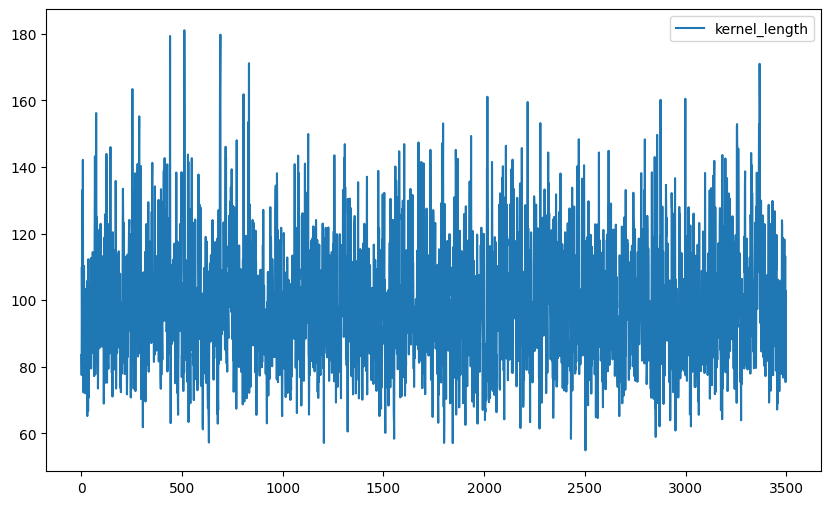

In [20]:
my_samples = flatten_samples(samples, ignore=[])
trace_plot_vars = ['kernel_length']
# for key in my_samples.keys():
#     if 'Omega' in key:
#         trace_plot_vars.append(key)
#     if 'sigmas' in key:
#         trace_plot_vars.append(key)

my_samples[trace_plot_vars].plot(subplots=True, figsize=(10,6), sharey=False)
plt.show()

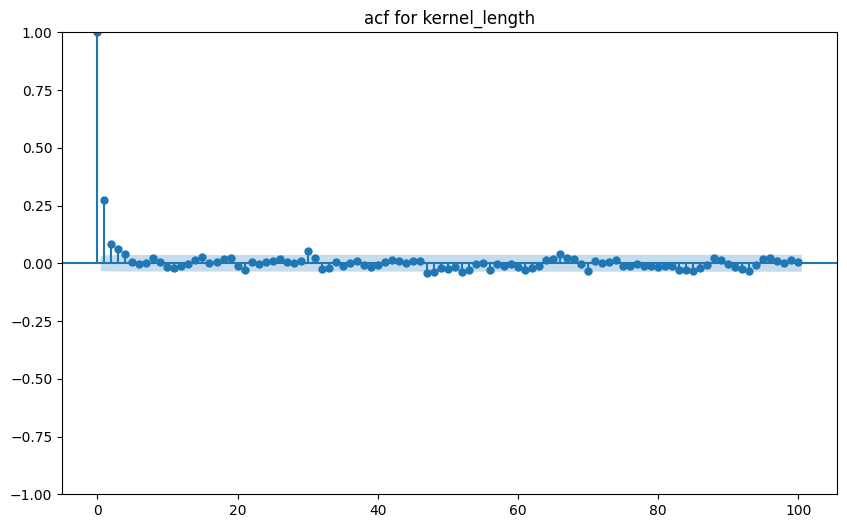

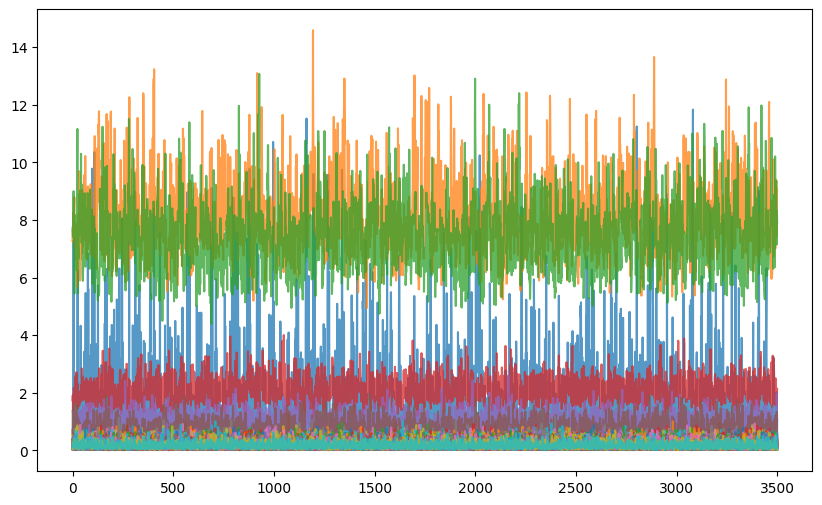

In [22]:
for var in trace_plot_vars:
    sm.graphics.tsa.plot_acf(my_samples[var], lags=config.plots.acf_lags)
    plt.title(f"acf for {var}")
    plt.show()

trace_plot_vars = []
for name in my_samples.columns:
    if "Omega" in name:
        trace_plot_vars.append(name)

my_samples.plot(y=trace_plot_vars,legend=False,alpha=0.75)
plt.show()

In [25]:
trace_plot_vars = []
for name in my_samples.columns:
    if "Omega" in name:
        plt.plot(my_samples[name])
        plt.title(name)
        plt.show()

In [26]:
trace_plot_vars = []
for name in my_samples.columns:
    if "Omega" in name:
        sm.graphics.tsa.plot_acf(my_samples[name], lags=config.plots.acf_lags)
        plt.title(name)
        plt.show()

In [29]:
in_sample_errors_df = pickle_load(job_path / "in_sample_errors_df.pickle")
in_sample_errors_df.head()

,x,y,errors,sd
0,0.000000,0.000000,0.003085,0.035982
1,0.000000,0.428571,0.002773,0.034882
2,0.000000,0.857143,0.002957,0.035334
3,0.142857,0.142857,0.029160,0.035025
4,0.142857,0.571429,0.030904,0.034721


In [37]:
in_sample_errors_df.describe()

,x,y,errors,sd
count,22.000000,22.000000,22.000000,22.000000
mean,0.500000,0.500000,0.013830,0.034768
std,0.343622,0.343622,0.011721,0.000612
min,0.000000,0.000000,0.002734,0.033842
25%,0.178571,0.178571,0.002790,0.034288
50%,0.500000,0.500000,0.012523,0.034707
75%,0.821429,0.821429,0.025399,0.035257
max,1.000000,1.000000,0.031075,0.035982


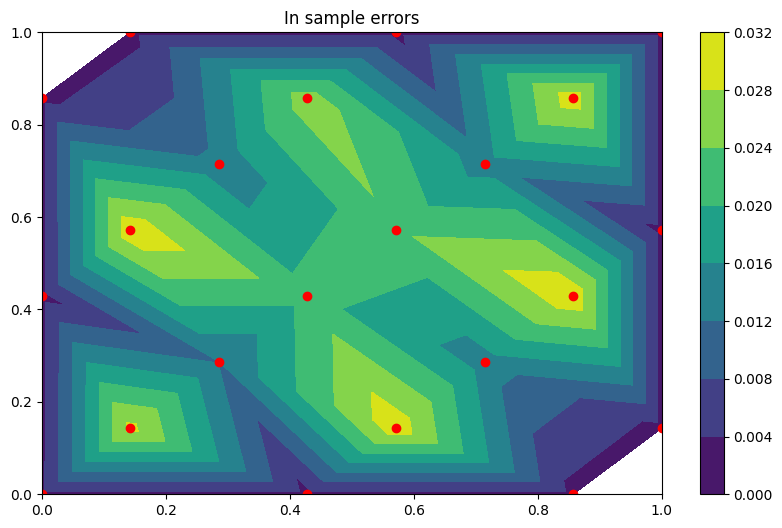

In [41]:
fig, ax = plt.subplots()
tcf = ax.tricontourf(in_sample_errors_df['x'],in_sample_errors_df['y'],in_sample_errors_df['errors'])
ax.scatter(in_sample_errors_df['x'],in_sample_errors_df['y'],c='r')
fig.colorbar(tcf)
plt.title("In sample errors")
plt.show()

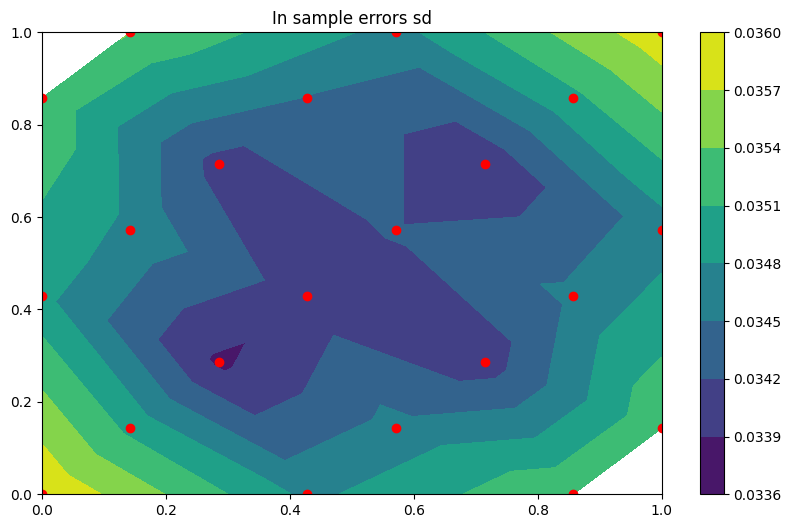

In [42]:
fig, ax = plt.subplots()
tcf = ax.tricontourf(in_sample_errors_df['x'],in_sample_errors_df['y'],in_sample_errors_df['sd'])
ax.scatter(in_sample_errors_df['x'],in_sample_errors_df['y'],c='r')
fig.colorbar(tcf)
plt.title("In sample errors sd")
plt.show()

In [32]:
out_sample_errors_df = pickle_load(job_path / "out_sample_errors_df.pickle")
out_sample_errors_df.head()

,x,y,errors_mean,errors_pred,sd_mean,sd_pred
0,0.0,0.000000,0.118266,0.118243,0.000899,0.029228
1,0.0,0.142857,0.103396,0.103381,0.000768,0.028192
2,0.0,0.285714,0.090353,0.090259,0.000708,0.027435
3,0.0,0.428571,0.080035,0.079983,0.000695,0.027086
4,0.0,0.571429,0.073599,0.074005,0.000768,0.027066


In [38]:
out_sample_errors_df.describe()

,x,y,errors_mean,errors_pred,sd_mean,sd_pred
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.500000,0.500000,0.106576,0.106594,0.000650,0.026540
std,0.329914,0.329914,0.035676,0.035671,0.000116,0.001396
min,0.000000,0.000000,0.053244,0.053151,0.000424,0.024275
25%,0.250000,0.250000,0.073348,0.073668,0.000574,0.025525
50%,0.500000,0.500000,0.101116,0.101148,0.000657,0.026577
75%,0.750000,0.750000,0.137383,0.137443,0.000737,0.027426
max,1.000000,1.000000,0.190216,0.190261,0.000899,0.029590


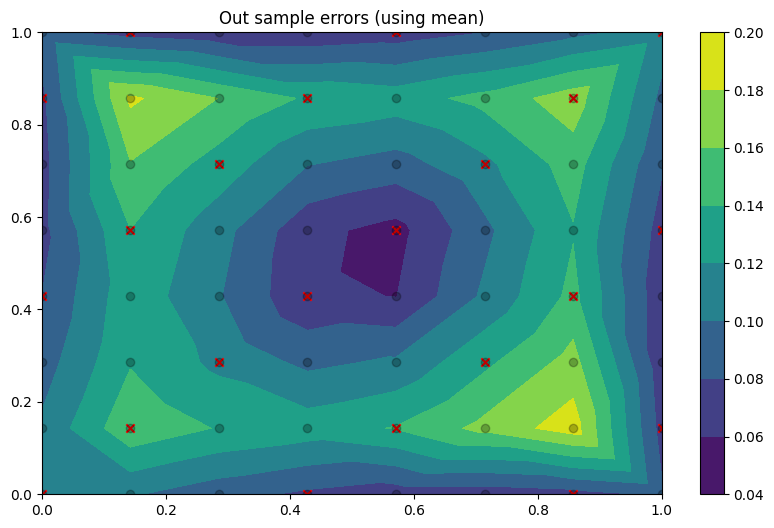

In [43]:
fig, ax = plt.subplots()
tcf = ax.tricontourf(out_sample_errors_df['x'],out_sample_errors_df['y'],out_sample_errors_df['errors_mean'])
ax.scatter(in_sample_errors_df['x'],in_sample_errors_df['y'],c='r',marker='x')
ax.scatter(out_sample_errors_df['x'],out_sample_errors_df['y'],c='black',alpha=0.25)
fig.colorbar(tcf)
plt.title("Out sample errors (using mean)")
plt.show()

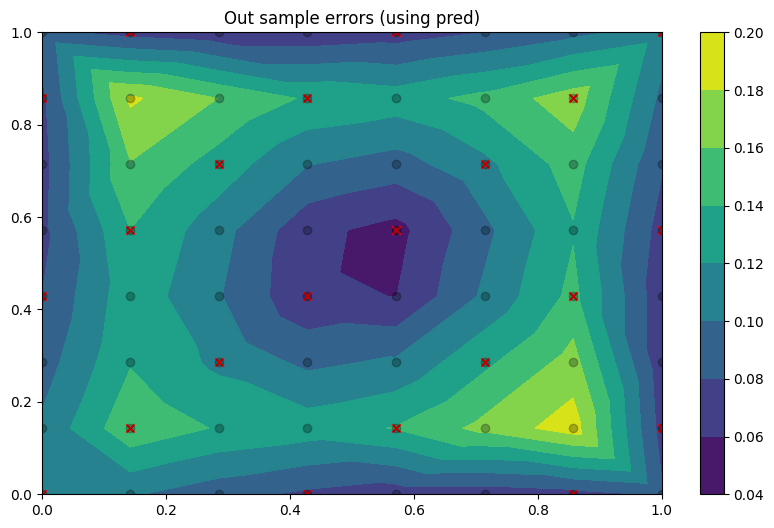

In [44]:
fig, ax = plt.subplots()
tcf = ax.tricontourf(out_sample_errors_df['x'],out_sample_errors_df['y'],out_sample_errors_df['errors_pred'])
ax.scatter(in_sample_errors_df['x'],in_sample_errors_df['y'],c='r',marker='x')
ax.scatter(out_sample_errors_df['x'],out_sample_errors_df['y'],c='black',alpha=0.25)
fig.colorbar(tcf)
plt.title("Out sample errors (using pred)")
plt.show()

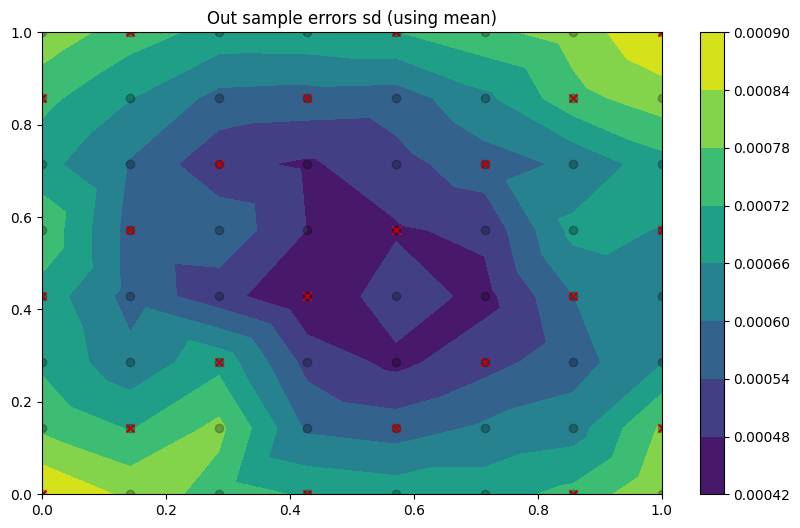

In [45]:
fig, ax = plt.subplots()
tcf = ax.tricontourf(out_sample_errors_df['x'],out_sample_errors_df['y'],out_sample_errors_df['sd_mean'])
ax.scatter(in_sample_errors_df['x'],in_sample_errors_df['y'],c='r',marker='x')
ax.scatter(out_sample_errors_df['x'],out_sample_errors_df['y'],c='black',alpha=0.25)
fig.colorbar(tcf)
plt.title("Out sample errors sd (using mean)")
plt.show()

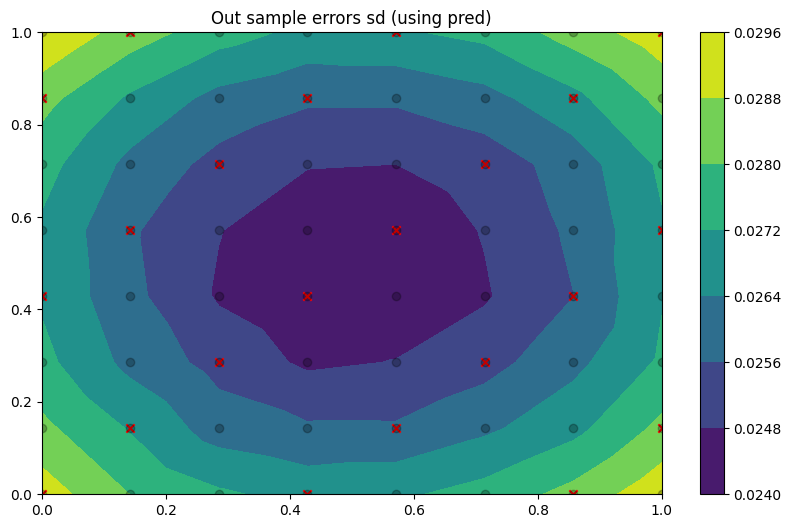

In [46]:
fig, ax = plt.subplots()
tcf = ax.tricontourf(out_sample_errors_df['x'],out_sample_errors_df['y'],out_sample_errors_df['sd_pred'])
ax.scatter(in_sample_errors_df['x'],in_sample_errors_df['y'],c='r',marker='x')
ax.scatter(out_sample_errors_df['x'],out_sample_errors_df['y'],c='black',alpha=0.25)
fig.colorbar(tcf)
plt.title("Out sample errors sd (using pred)")
plt.show()